In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
#specify the computational domain
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [16]:
#specify the PDE
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0) 
    return (
        dy_t
        - C * dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )
C = dde.Variable(2.0)

In [17]:
#define the reference solution
def func(x):
    return(
        np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])
    )


In [18]:
#specify the boundary and initial conditions
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary) # lambda _, on_boundary: on_boundary checks if the point is on the boundary or not
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

In [19]:
observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

In [20]:
#combine the geometry, PDE and boundary/initial conditions to data.PDE
data = dde.data.TimePDE(geomtime, pde, [bc, ic, observe_y], num_domain=40, num_boundary=20, num_initial=10, anchors=observe_x, solution=func, num_test=10000,)

In [21]:
#define the neural network
net = dde.nn.FNN([2] + [32]*3 + [1], "tanh", "Glorot uniform")

In [22]:
#combine data.PDE with neural network to make the model
model = dde.Model(data, net)

In [24]:
#compile
model.compile("adam", lr=0.01, metrics=["l2 relative error"], external_trainable_variables=C)

Compiling model...
'compile' took 0.181696 s



In [31]:
#train
variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

Training model...

Step      Train loss                                  Test loss                                   Test metric   
150000    [3.47e-05, 2.09e-06, 1.90e-06, 2.96e-06]    [1.48e-03, 2.09e-06, 1.90e-06, 2.96e-06]    [7.25e-03]    
150000 [9.92e-01]
151000    [2.42e-05, 2.21e-06, 1.38e-06, 8.81e-07]    [1.58e-03, 2.21e-06, 1.38e-06, 8.81e-07]    [4.99e-03]    
151000 [9.95e-01]
152000    [7.97e-05, 3.69e-06, 2.36e-06, 2.36e-06]    [1.72e-03, 3.69e-06, 2.36e-06, 2.36e-06]    [4.72e-03]    
152000 [9.96e-01]
153000    [5.96e-05, 4.29e-06, 2.28e-06, 9.94e-07]    [2.00e-03, 4.29e-06, 2.28e-06, 9.94e-07]    [4.52e-03]    
153000 [9.97e-01]
154000    [1.39e-04, 7.60e-05, 1.15e-04, 6.63e-05]    [2.13e-03, 7.60e-05, 1.15e-04, 6.63e-05]    [2.11e-02]    
154000 [9.96e-01]
155000    [6.48e-04, 1.41e-04, 1.39e-04, 1.25e-04]    [2.53e-03, 1.41e-04, 1.39e-04, 1.25e-04]    [2.50e-02]    
155000 [9.96e-01]
156000    [1.07e-05, 1.82e-06, 5.98e-07, 2.84e-07]    [2.16e-03, 1.82e-06, 5.98e-0

Saving loss history to /Users/bipuladhikari/Documents/neuralNetwork/myDeepXDE/diffusionReaction/loss.dat ...
Saving training data to /Users/bipuladhikari/Documents/neuralNetwork/myDeepXDE/diffusionReaction/train.dat ...
Saving test data to /Users/bipuladhikari/Documents/neuralNetwork/myDeepXDE/diffusionReaction/test.dat ...


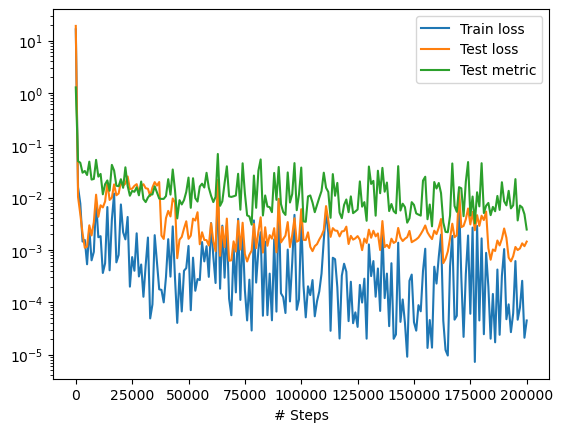

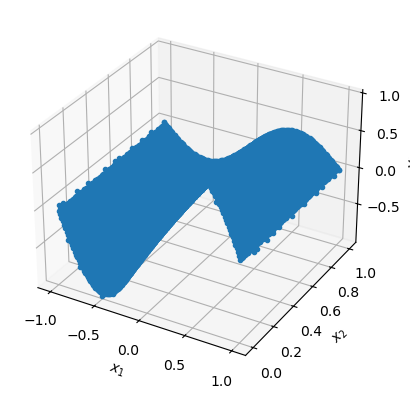

In [32]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)